# 基于张国荣歌曲歌词词云分析张国荣

In [ ]:
'''
    利用网易云音乐API获取张国荣歌词
'''
import requests
from bs4 import BeautifulSoup
import re
import csv
import time

# url = "https://music.163.com"
s = requests.session()
s.keep_alive = False # 关闭多余链接
headers = {
    'Referer': 'https://music.163.com',
    'Host': 'music.163.com',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36',
}

def get_songs(artist_id):
    url = f'https://music.163.com/artist?id={artist_id}'
    web_page = requests.get(url,headers=headers)
    soup = BeautifulSoup(web_page.text,'lxml')
    songs_meta = soup.select('ul.f-hide > li > a')
    songs = [{'id': song.get('href')[9:],'name': song.get_text()} for song in songs_meta]

    return songs

def get_song_lyric(song_id):
    url = f'https://music.163.com/api/song/lyric?id={song_id}&lv=1&kv=1&tv=-1'
    res = requests.get(url, headers=headers)
    if 'lrc' in res.json():
        lyric = res.json()['lrc']['lyric']
        lyric = re.sub(r'[\d:.[\]]', '', lyric) 
        return lyric
    else:
        return ''

# 保存 张国荣 歌曲、歌词
songs = get_songs(6457)
with open('./张国荣/song.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['id', 'name', 'lyric'])
for song in songs:
    lyric = get_song_lyric(song['id'])
    with open('./张国荣/song.csv', 'a+', encoding='utf-8-sig') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([song['id'], song['name'], lyric])
    time.sleep(1)

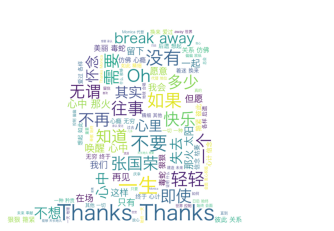

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import jieba

data = pd.read_csv('./张国荣/song.csv')
lyrics = data['lyric'].tolist()
all_word = ''
for lyric in lyrics:
    all_word += ' ' + lyric

with open('./stop_words.txt', 'r', encoding='utf-8') as f:
    stop_words = [line.strip() for line in f.readlines()]

# 创建背景图
mask = np.asarray(Image.open('./张国荣/张国荣-rm-bg.jpg'))

# 去掉停用词
def remove_stop_words(f, stop_words):
     for stop_word in stop_words:
           f = f.replace(stop_word, '')
     return f

# 生成词云
def create_word_cloud(f, stop_words, mask=None):
    f = remove_stop_words(f, stop_words)
    cut_text = ' '.join(jieba.cut(f, cut_all=False, HMM=True))
    wc = WordCloud(
        mask=mask,
        font_path='/System/Library/Fonts/Hiragino Sans GB.ttc',
        background_color='#FFFFFF',
        width=2188,
        height=2472,
        scale=2,
        max_words=100,
    )
    wordcloud = wc.generate(cut_text)
    wordcloud.to_file('./张国荣/张国荣歌词词云.jpg')
    plt.imshow(wordcloud)
    plt.axis('off') # 不显示坐标
    plt.show()

create_word_cloud(all_word, stop_words, mask)